# Practical session 4: Modulating internal states and Sensing other agent's attributes

In the last practical session, we saw how to run multiple behaviors in parallel on multiple agents. In this section we will see more advanced methods for combining behaviors by modulating their activations according to internal states of the agent and by allowing them to sense the attributes of others (e.g. their color or their size). 

**Reminder:** Work on a copy of this notebook and save your work as indicated at the beginning of the `session_1.ipynb` notebook.

As usual, let's first import the functions `start_server_and_interface` and `stop_server_and_interface`, and the `NotebookController` class. Then start the server and interface for this session, create a controller object to interact with the simulator and run it. The code below does this:

In [ ]:
from vivarium.controllers.notebook_controller import NotebookController
from vivarium.utils.handle_server_interface import start_server_and_interface, stop_server_and_interface

In [ ]:
start_server_and_interface(scene_name="session_4")

In [ ]:
controller = NotebookController()
controller.run()

Wait until the interface link shows up (it should be http://localhost:5006/run_interface or similar) and open it in a new browser window. Keep both this notebook and the interface windows open, ideally side by side.
In the interface, you will see the scene we will use in this session. It contains three agents (the blue circles), and three different types of objects (green, orange and red squares). Each of these four types of entities is identified by a subtype name that you can access with:

In [ ]:
controller.print_subtypes_list()

`s_obstacles` stands for small obstacles (orange squares), `b_obstacles` for big obstacles (red squares) and `resources` are the green squares. `agents` are the blue circle agents. Those labels can be used to selectively sense each of these entity subtypes, as we have seen in session 3.

In order to start with a clean basis, let's first provide the definition of several behaviors. These four behaviors are simply implementations of the [Braitenberg vehicles](https://docs.google.com/presentation/d/1s6ibk_ACiJb9CERJ_8L_b4KFu9d04ZG_htUbb_YSYT4/edit#slide=id.g31e1b425a3_0_0) we have seen in class, where the `sensed_entities` (i.e. what is sensed by the proximeters) are other `agents`:

In [ ]:
def fear(agent):
    left, right = agent.sensors(sensed_entities=["agents"])
    left_wheel = left
    right_wheel = right
    return left_wheel, right_wheel

def aggression(agent):
    left, right = agent.sensors(sensed_entities=["agents"])
    left_wheel = right
    right_wheel = left
    return left_wheel, right_wheel

def love(agent):
    left, right = agent.sensors(sensed_entities=["agents"])
    left_wheel = 1 - left
    right_wheel = 1 - right   
    return left_wheel, right_wheel

def shyness(agent):
    left, right = agent.sensors(sensed_entities=["agents"])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

We define a fifth behavior for obstacle avoidance, where obstacles are orange and red squares, labeled `s_obstacles` and `b_obstacles`.

In [ ]:
def obstacle_avoidance(agent):
    left, right = agent.sensors(sensed_entities=["s_obstacles", "b_obstacles"])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

## Analyzing agents interactions

Let's now analyze the interaction between two agents that are equipped with different behaviors. First assign a variable to each agent of the simulation so we can easily access them indivually in the next steps. As we saw in previous sessions, the `controller.agents` is a list, and we can access its elements with Python indexing system (0 corresponding to the first element, 1 to the second etc). 

In [ ]:
agent_0 = controller.agents[0]
agent_1 = controller.agents[1]
agent_2 = controller.agents[2]

To differentiate the agents, we will also assign them different colors:

In [ ]:
agent_0.color = "blue"
agent_1.color = "cyan"
agent_2.color = "black"

**Q1:** In addition to the `obstacle_avoidance` behavior, run several combinations of the four other behaviors defined above. For example, run `obstacle_avoidance` and `fear` on `agent_0` ; and `obstacle_avoidance` and `aggression` on `agent_1`. Keep the `agent_2` still for the moment. Find two of these combinations that you consider as interesting (e.g. because they result in a relatively complex interaction pattern, or because they can be linked to standard animal behavior, e.g. prey-predator) and describe them in a few lines:

In [ ]:
# Your code here

*Your answer here*

This session's environment contains more entities than previous ones, which might slow down the simulation. In case it is very slow on your computer, you can increase the number of steps the simulation performs on the server for each step done by the controller. To do this, open the `SIMULATOR` panel in the web interface and find the `num_steps_lax` parameter. It is set to 6 by default; you can e.g. double it to 12 to see if the simulation runs faster. Make sure to use this mechanism wisely, as increasing this number too much might lead to a simulation that is less reactive to your commands.

## Weighting behaviors

As we have seen in the previous sesssion and in the question above, it is possible to run several behaviors in parallel on the same agent. When doing it, the motor activation sent to each wheel corresponds to the average of the motor activation returned by each behavior (this averaging is implemented internally, you don't need to worry about it). 

It is also possible to specify the weight of each running behavior, i.e. how much it will count in the averaging. This is done by passing an optional `weight` argument to the `attach_behavior` method. For example, if we want to run the `obstacle_avoidance` behavior with a weight of 1 and the `fear` behavior with a weight of 0.5 on `agent_2`, we write:

In [ ]:
agent_2.attach_behavior(obstacle_avoidance, weight=1)
agent_2.attach_behavior(fear, weight=0.5)

It might be hard to effectively see the weights in action for these two behaviors as they both lead the agent to avoid other entities. In order to better visualize the effect of the weights, we will define two new behaviors with opposite effects: `aggress_all` and `avoid_all`. The `aggress_all` behavior will make the agent move towards all other entities, while the `avoid_all` behavior will make it move away from them. We will add a bigger weight to the `aggress_all` behavior than to the `avoid_all` behavior, and observe the agent's behavior.

In [ ]:
def aggress_all(agent):
    left, right = agent.sensors()  # This senses all entities
    left_wheel = right
    right_wheel = left  
    return left_wheel, right_wheel

def avoid_all(agent):
    left, right = agent.sensors()  # This senses all entities
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

In [ ]:
agent_2.detach_all_behaviors()
agent_2.attach_behavior(aggress_all, weight=1)
agent_2.attach_behavior(avoid_all, weight=0.2)

**Q2:** What are the effects of the weights on the agent's behavior? Why does it keep moving even when it doesn't sense anything ? Describe the observed behavior in a few lines:

*Your answer here*

By doing this, the wheel activations returned by the `agress_all` behavior will have more weight than those returned by the `avoid_all` behavior. For example, if `avoid_all` returns 0.6 for the left wheel, and `agress_all` returns 0.9, then the total activation of that wheel will be $(0.6 * 0.2 + 0.9 * 1) / (0.2 + 1) = 0.85$ (i.e. the average of both values weighted by their respective activation). Note that when the `weight` argument is not provided to the `attach_behavior` method, the corresponding behavior is set with a default weight of 1.

## Weighting behaviors according to internal states

This weighting is particularly useful to activate a behavior according to some internal states of the agent. Let's consider the following scenario:

- Agents can eat resources (as in the previous session)
- Agents have a simulated "energy level", which decreases with time and increases whenever they consume a resource.
- Agents execute a `foraging` behavior towards resources, with a weight depending on their current energy level: The lower the energy level, the higher the weight.

In the following we will implement this scenario step by step.

Let's first detach all current behaviors:

In [ ]:
for agent in controller.agents:
    agent.detach_all_behaviors(stop_motors=True)

### Defining a foraging behavior

Then let's define a `foraging` behavior (attraction towards resources):

In [ ]:
def foraging(agent):
    left, right = agent.sensors(sensed_entities=["resources"])
    left_activation = right
    right_activation = left
    return left_activation, right_activation

We also need to add `resources` to the diet of agents to enable consuming them, as we did in session 3:

In [ ]:
# Add resources to the all agents' diet
for agent in controller.agents:
    agent.diet = ["resources"]

This way the agent will "eat" a resource whenever it is close to it (it will be effective only when we will have activated the eating mechanism below). 
Do not attach the `foraging` behavior yet, we'll do it later

### Knowing when an agent has eaten something

To implement the scenario proposed above, we need to continuously compute the energy level of an agent according to how much resources it has recently eaten. To do so, we first need a way to know when a agent has eaten for the last time. There are several ways of doing this that can serve in different use cases:

- `agent.has_eaten()`: method returning `True` if the agent has eaten since the last call to this function, `False` otherwise (defaults to False the first time it is called).
- `agent.time_since_feeding`: attribute indicating the time since the last time an agent has eaten (defaults to infinity when the agent has never eaten).
- `agent.has_eaten_since(t)`: method returning if the agent has eaten since time `t`.

Let's print the current values for `agent_0`:

In [ ]:
print(f"agent_0.has_eaten(): {agent_0.has_eaten()} ;  agent_0.time_since_feeding: {agent_0.time_since_feeding}")

We can see than when agents haven't started eating, the `has_eaten` method returns `False` and the time since feeding is infinite (`inf`). When it will eat something, the time since feeding will be reset to 0, and the `has_eaten` method will return True. Note that currently agents can't eat anything since we haven't yet activated the eating mechanism.

We can also check these values for all agents in the scene at once by iterating through the `controller.agents` list:

In [ ]:
for agent in controller.agents:
    print(f"agent_{agent.idx}.has_eaten(): {agent.has_eaten()} ;  agent_{agent.idx}.time_since_feeding: {agent.time_since_feeding}")

**Q3:** Remove all current behaviors still running on the agents (if any). Then attach the `obstacle_avoidance` and `foraging` on all agents. Check that they are correctly attached and started with the `print_behaviors` method of the agents.

In [ ]:
# your code here

Now let's start the eating mechanism and the spawning of resources as in session 3:

In [ ]:
# Start resources apparition and eating mechanism
controller.start_resources_apparition(interval=50)
controller.start_eating_mechanism(interval=10)

Let's check if the values of `has_eaten` and `time_since_feeding` evolve for all agents (execute the cell below several time and check that the values change consistently when agents eat resources):

In [ ]:
for agent in controller.agents:
    print(f"agent_{agent.idx}.has_eaten(): {agent.has_eaten()} ;  agent_{agent.idx}.time_since_feeding: {agent.time_since_feeding}")

### Using routines to modulate agent's internal states

Now we want to continuously compute the energy level of an agent, so that the level decreases slowly when nothing is eaten and increases whenever a resource is consumed. This can be done by attaching to agents what we call a **routine**. The definition of a *routine* is very similar to the definition of a *behavior*: It is defined as a Python function taking an agent as argument. The main difference is that a function defining a routine doesn't return any value (whereas a behavior always returns the left and right wheel activations). Thus, a routine corresponds to a set of instructions that are executed at a particular interval on an agent (similarly to a behavior), e.g. to compute some agent's internal states according to its interaction with the environment.

Let's define a routine called `energy` that computes an energy level as specified above. In order to do so, we will first define a few parameters, such as the initial and the maximum level of energy of agents. Then, we will set an initial `energy_level` attribute to each agent:
 

In [ ]:
max_energy_level = 1.
init_energy_level = 0.5

for agent in controller.agents:
    agent.energy_level = init_energy_level

Let's check we can access this attribute for all agents in the next cell.

In [ ]:
for agent in controller.agents:
    print(f"agent_{agent.idx} energy level is: {agent.energy_level}")

Now, if you execute the cell above several times, note that the `energy_level` attribute of the agents remains the same because we didn't do anything to update it yet. Let's change this by defining the `energy` routine as follows. As for a behavior, the function defining a routine takes an agent as an argument, representing the agent on which the routine will be attached. 

In [ ]:
# Similarly to a behavior, a routine is defined as a function that takes an agent as argument
# The only difference is that a routine does not return anything (whereas a behavior returns the left and right wheel activations)
def energy(agent): 
    if agent.has_eaten():
        # if the agent has eaten a resource since the last execution of the routine, increase its energy level
        agent.energy_level += 0.5  # This is equivalent to agent.energy_level = agent.energy_level + 0.5
    else:
        # decrease energy level
        agent.energy_level -= 0.01  # otherwise (nothing eaten), decrease the energy level a bit
    # The line below bounds the value of the energy level between 0 and max_energy_level
    agent.energy_level = min(max_energy_level, max(agent.energy_level, 0.))

As for a behavior, we then need to attach the routine to an agent, which is done with the `attach_routine` method. When attaching a routine, we can also pass an optional `interval` argument to specify every each step it will be executed (defaults to 1). Let's attach the `energy` routine to `agent_0` such that it is executed every 10 steps:

In [ ]:
# Attach the energy routine to agent_0, which will be executed every 10 steps
agent_0.attach_routine(energy, interval=10)

Note that before attaching a routine where we update the attribute of an agent, we need to make sure this attribute has been previously initialized. Otherwise the routine will raise an error because it will attempt to access an agent attribute that does not exist. This is why we previously defined the `energy_level` attribute a few cells above (setting it to the initial energy value) before attaching the routine. Whenever you write a routine, you need to make sure that all attributes accessed in it have been previously initialized. 



Let's check that the energy level of `agent_0` changes according to time and the consumption of resources by executing several time the cell below:

In [ ]:
print(agent_0.energy_level)

**Q4:** How does the value change when the agent eats a resource ? What happens when it doesn't eat for a while ?

*Your answer here*

### Weighting a behavior according to an agent's internal state

To complete the implementation of our scenario, we finally need to weight the `foraging` behavior according to energy level of the agent. The lower the energy level, the higher `foraging` is weighted. We have seen above how we can weight a behavior when attaching it. We can also dynamically change it (i.e. while the behavior is running on the agent) with the `change_behavior_weight` method:

In [ ]:
# Change the weight of the foraging behavior on agent_0 to 0.5:
agent_0.change_behavior_weight(foraging, new_weight=0.5)

Try different values of the `new_weight` argument above and check that the `agent_0` (the dark blue one) behaves as expected. In particular, if the weight is set to 0, you should observe that agent no longer forage for resources.

Since we want this weight to be continuously updated according the current energy level of an agent, we can define another routine for doing this. Let's call this new routine `foraging_weight`:

In [ ]:
def foraging_weight(agent):
    # This routine changes the weight of the foraging behavior according to the current energy level
    # The lower the energy level, the higher the weight (energy level is bounded between 0 and 1 in the energy routine)
    # E.g., if the energy is 1 (maximum value), the behavior weight will be 0 (and vice versa)
    agent.change_behavior_weight(foraging, 1 - agent.energy_level)

Let's attach the `foraging_weight` routine to `agent_0`:

In [ ]:
# Attach the foraging_weight routine to agent_0, which will be executed every 10 steps
agent_0.attach_routine(foraging_weight, interval=10)

Now the weight of the `foraging` behavior of `agent_0` is modulated by its energy level, as implemented in the `foraging_weight` routine above.  

We can check the current weights of all attached behaviors with the `print_behaviors` method by setting the `full_infos` argument to `True`:

In [ ]:
agent_0.print_behaviors(full_infos=True)

You can re-execute the cell above several times to check that the weight of the `foraging` behavior of `agent_0` is modulated according to the energy level as expected.

You can detach the routine from an agent similarly to a behavior with the `detach_routine` and `detach_all_routines` functions, and check them with the `print_routines` function.

In [ ]:
# Only detach the foraging_weight routine
agent_0.detach_routine(foraging_weight)

# Detach all currently attached routines
agent_0.detach_all_routines()

If you re-execute the `print_behaviors` method above several times, you should observe that the weight of the `foraging_behavior` is no longer modulated by the energy level (i.e. the weight remains constant at its last value).

### Wrapping it up
We now have all the ingredients for our scenario. Let's wrap it up by detaching all attached behaviors and routines, attaching both the `obstacle_avoidance` and `foraging` behaviors as well as both the `energy` and `foraging_weight` routines, to all agents:

In [ ]:
for agent in controller.agents: # For all agents
    agent.detach_all_behaviors(stop_motors=True)  #Detach all previously attached behaviors
    agent.detach_all_routines()  #Detach all previously attached routines
    agent.attach_behavior(foraging)  # Attach the foraging behavior
    agent.attach_behavior(obstacle_avoidance)  # Attach the obstacle avoidance behavior
    agent.attach_routine(energy, interval=10)  # Attach the energy routine
    agent.attach_routine(foraging_weight, interval=10)  # Attach the foraging_weight routine

Note that the `foraging_weight` routine has to be attached **after** the `foraging` behavior, because this routine changes the weight of the behavior. If the routine is attached before the behavior, it might raise an error because it will try to access a behavior that is not yet attached.

In the interface, you should observe that all agents are indeed avoiding obstacles (red and orange squares), are attracted toward resources and consume them. When they eat a few resources in a row, their energy level approaches the maximum value. In this situation, you should observe that the agents are no longer attracted toward resources, until their energy level decreases again. You can check the corresponding values by printing the energy level and the behavior weights of all agents:

In [ ]:
for agent in controller.agents:
    print(f'agent_{agent.idx}')
    print('------------')
    print(f'energy level: {agent.energy_level}')
    agent.print_behaviors(full_infos=True)
    print('\n')

**Q5:** Detach the `energy` routine on all agents (only this routine, not the `foraging_weight` one) and set the energy level of all agents to 1 (i.e. the maximum value). Describe what happens in this case.

In [ ]:
# Your code here

*Your answer here*

Now detach all the behaviors and the routines before going to the next section.

In [ ]:
for agent in controller.agents:
    agent.detach_all_routines()
    agent.detach_all_behaviors(stop_motors=True)

## Sensing entity's attributes

It can be useful to allow an agent to sense attributes of other entities. As a reminder, we call "entity" any item present on the scene, either agents or objects (as explained in the [web interface tutorial](../tutorials/web_interface_tutorial.md)). For example, one might want to define different species of agents (cats and mouses for example) such that how an agent interacts with another depends on their respective species. To achieve this we can define arbitrary attributes of agents, e.g `agent.species = "cat"` and that attribute can be "sensed" by other agents whenever it is detected by a proximeter sensor. Let's try it with three agents. 

We define a `species` atttribute for all agents (`species` is an arbitrary attribute name, it could be anything else). The species of `agent_0` is `"cat"` and we make it bigger, and the species of `agent_0` and `agent_1` is  `"mouse"`  and we maked them smaller. We also  change the color of mouses to distinguish them from the cat:

In [ ]:
# set attributes of agent 0
agent_0.species = "cat"
agent_0.diameter = 12.

# set the same attributes for agent 1 and agent 2, and change their color
agent_1.species = agent_2.species = "mouse"
agent_1.diameter = agent_2.diameter = 7.
agent_1.color = agent_2.color = "cyan"

So we have one cat and two mouses. Place the agents (either with the interface or with code) so that `agent_2` (mouse) is sensing `agent_0` (cat) on its left proximeter and `agent_1` (mouse) on its right proximeter. You can set the position of an entity by using its `x_position` and `y_position` attributes. For instance you can do it with the following commands:

In [ ]:
from numpy import pi  # import the number pi, we'll use it to set the agent orientation

# First place the agent 2 at a specific location, and make it face the top of the environment
agent_2.x_position = 150
agent_2.y_position = 150
agent_2.orientation = pi / 2  # Orientations are specified in radians, with 0 corresponding to the left direction. He we set it to pi / 2, making the agent face the top direction. 

In [ ]:
# Then, place the two other agents accordingly so they are sensed on the left and right of agent 2
agent_0.x_position = 130
agent_0.y_position = 170

agent_1.x_position = 170
agent_1.y_position = 170

Just make sure there are no objects sensed between `agent_2` (at the bottom) and the two other agents. You can manually move the objects in the interface if it is the case. The center of your scene should look roughly like this image:

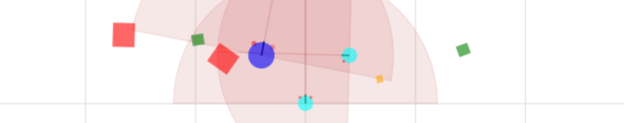

Then, to return the entities sensed by the left and right proximeters of `agent_2`, we can use the `entity_sensors` method of the agents. This returns a reference to the closest left and right entities within the agent field of view, if any, and `None` otherwise. 

In [ ]:
ent_left, ent_right = agent_2.entity_sensors()

We can check what are the entities sensed by an agent by running the following cell. Let's analyze it with more details. First, we print infos for the entity sensed by the left sensor. We start by ensuring it exists with `if ent_left:`, because it is possible that no entity is sensed and this value will therefore be `None`. Then if the entity exists, we print its infos with the `print_infos()` method, else we just print that there are no entity sensed on this side. We do the same on the right side.

In [ ]:
# Print the infos of the sensed entities
print("Entity sensed by the left sensor:")
if ent_left:
    ent_left.print_infos()
else:
    print("No entity sensed")

print("Entity sensed by the right sensor:")
if ent_right:
    ent_right.print_infos()

else:
    print("No entity sensed")

If the three agents were placed as specified above, the left entity should be the `agent_O` (Idx: 0) and the right entity should be `agent_1` (Idx: 1). Note that the `ent_left` and `ent_right` entities are the exact same as the `agent_0` and `agent_1` ones, respectively. In Python, we can check they are the same using the `==` sign: 

In [ ]:
ent_left == agent_0

If the cell above returns `True`, it means that the left entity returned by the `agent_2.entity_sensors()` method is (literally) `agent_0`. We can therefore manipulate the `ent_left` variable the exact same way we would manipulate any agent variable. Let's for example access its diameter:

In [ ]:
print(ent_left.diameter)

and its species (that was defined above):

In [ ]:
print(ent_left.species)

We can also directly sense specific attributes of the sensed entities in a single line of code with the `attribute_sensors` method. The method expects a `sensed_attribute` argument, indicating which attribute we want the agent to sense (e.g 'diameter', 'species', etc.). 

For example, let's directly access the `diameter` attribute of the entities sensed by `agent_2`:

In [ ]:
l_attr, r_attr = agent_2.attribute_sensors(sensed_attribute="diameter")
print(f"Diameter of the entity sensed by the left sensor: {l_attr}")
print(f"Diameter of the entity sensed by the right sensor: {r_attr}")

If you correctly positioned the three agents as specified above, it should return two numbers indicating the diameter of the agents sensed by the left and right sensors of `agent_2`. Otherwise, it is possible that the value of one sensor returns `None`: in that case, it means that either no entity was sensed, or that the attribute does not exist on the sensed entity. We can return another value than `None` in that case by specifying a `default_value` argument. The `attribute_sensors` method will return the given attribute of the left and right sensed entities if it exists, and the default value otherwise.

Let's access the `species` attribute of the sensed entities, setting `default_value` to the string `"unknown"`. If no entity is detected by the sensor, or if the sensed entity has no `species` attribute (it will be e.g. the case if the sensed entity is an object), the method will return 'unknown'.

In [ ]:
l_attr, r_attr = agent_2.attribute_sensors(sensed_attribute="species", default_value="unknown")
print(f"Left: {l_attr} Right: {r_attr}")

Note that these two methods, `entity_sensors` and `attribute_sensors`, work with any type of sensed entities, either agent or objects.

**Q6:** Define an `age` attribute on all agents and write the code to sense it. Then write the code to sense the `orientation` attribute of any entity (the `orientation` attribute already exist on both agents and objects, no need to define it). 

In [ ]:
# Your code here

By moving agents in the scene (either on the web interface of with code), check that an agent can indeed sense the `age` attribute of other agents, but that the `default_value` is returned when it instead senses an object. Also check that to `orientation` attribute can be sensed on any entity, either agents or objects.

The methods explained above enable to implement more complex scenarios. Let's for example constrain the `fear` behavior so that mouses are only afraid by the cat but not by the other mouse:

In [ ]:
def fear_cat(agent):
    # Access the proximeter values as we did in previous sessions, selectively sensing other agents
    left, right = agent.sensors(sensed_entities=["agents"])

    # Access the species attribute of the sensed entities
    left_species, right_species = agent.attribute_sensors(sensed_attribute="species")
    
    # Compute wheel activation depending on whether a cat was sensed or not
    left_activation = left if left_species == "cat" else 0  # set the left wheel to the left proximeter value (i.e. fear behavior) if the sensed entity is a cat, 0 otherwise
    right_activation = right if right_species == "cat" else 0  # Idem on the right side
    
    # Return wheel activations as usual
    return left_activation, right_activation

Attach the obstacle avoidance on all agents to make them move.

In [ ]:
for agent in controller.agents:
    agent.attach_behavior(obstacle_avoidance)

Also attach the `fear_cat` behavior on the two mouses:

In [ ]:
for agent in controller.agents:
    if agent.species == "mouse":  # Only attach the fear_cat behavior to mouse 
        agent.attach_behavior(fear_cat)

Check in the simulator that the two mouses (small cyan agents) are now avoiding the cat (bigger dark blue agent) but not the other mouse.

We can also modify the `species` attribute of agents on the fly. Let's swap the species of `agent_0` and `agent_1`:

In [ ]:
# Change agent_O to a green mouse
agent_0.species = "mouse"
agent_0.diameter = 7.
agent_0.color = "green"

# Change agent_1 to a blue cat
agent_1.species = "cat"
agent_1.diameter = 12.
agent_1.color = "blue"

# Since agent_1 is now a cat, we can detach the fear_cat behavior from it
agent_1.detach_behavior(fear_cat)

Check in the simulator that `agent_2` (cyan mouse) is now avoiding `agent_1` (the new cat) but not `agent_0` (the new green mouse). 

**Q7:** Use the new functionalities we have seen in this session to design the following scenario:
The three agents are equipped with behaviors to avoid obstacles and forage for resources, as well as being attracted or repulsed by other agents (i.e. 4 behaviors in total). Attraction and repulsion depend on the energy level of the sensed agent: the higher this level the more attraction, the lower this level the more repulsion. 

In [ ]:
# first detach all the potential behaviors and routines currently attached
for agent in controller.agents:
    agent.detach_all_behaviors(stop_motors=True)
    agent.detach_all_routines()

In [ ]:
# Your code here


That's it for this session. As usual, don't forget to properly close it with:

In [ ]:
stop_server_and_interface(safe_mode=False)
controller.stop()

Now that you finished this session, you can jump to :

- [session 5](session_5_logging.ipynb) : How to log and plot data about the simulation 